<font color='maroon' size='6'>**Supervised Learning: Classification & Model Evaluation**</font> 
----
----

### *Agenda*
 
     1- Supervised Learning - Classification
        - Decision Tree
        - Logistic Regression
        - K-Nearest Neighbors (KNN) Classification
        - Naive Bayes Classification
    2- Evaluation Metrics
        - Confusion Matrics
        - ROC Curve
    3- Model Evaluation
        - Cross-Validation

<font color=red size='5'>**Decision Tree (DT)**</font> 
----
----


A decision tree is a decision support hierarchical model that uses a tree-like model of decisions and their possible consequences, including chance event outcomes, resource costs, and utility. It is one way to display an algorithm that only contains conditional control statements.[[Wiki]](https://en.wikipedia.org/wiki/Decision_tree#:~:text=A%20decision%20tree%20is%20a,only%20contains%20conditional%20control%20statements.)


<font color=maroon size='4'>**Entropy**</font> 
----
------

Shannon's entropy is defined for a system with N possible states as follows:

$$S = -\sum_{i=1}^{N}p_i \log_2{p_i},$$


where $p_i$ is the probability of finding the system in the $i$-th state. This is a very important concept used in physics, information theory, and other areas. Entropy can be described as the degree of chaos in the system. The higher the entropy, the less ordered the system and vice versa. This will help us formalize "effective data splitting"

#### Toy Example
To illustrate how entropy can help us identify good features for building a decision tree, let's look at a toy example. We will predict the color of the ball based on its position.


----
<img src='decisionTree3.png'  width="75%" height="75%">

-----


There are 9 blue balls and 11 yellow balls. 

If we randomly pull out a ball, then it will be blue with probability $p_1=\frac{9}{20}$ and yellow with probability $p_2=\frac{11}{20}$,  which gives us an entropy:

$S_0 = -\frac{9}{20}\log_2{\frac{9}{20}}-\frac{11}{20}\log_2{\frac{11}{20}} \approx 1$. 

This value by itself may not tell us much, but let's see how the value changes if we were to break the balls into two groups: with the position less than or equal to 12 and greater than 12.

----
<img src='decisionTree4.png'  width="75%" height="75%">

-----


The left group has 13 balls, 8 blue and 5 yellow. 

The entropy of this group is 

$S_1 = -\frac{5}{13}\log_2{\frac{5}{13}}-\frac{8}{13}\log_2{\frac{8}{13}} \approx 0.96$. 

The right group has 7 balls, 1 blue and 6 yellow. 

The entropy of the right group is 

$S_2 = -\frac{1}{7}\log_2{\frac{1}{7}}-\frac{6}{7}\log_2{\frac{6}{7}} \approx 0.6$. 

As you can see, entropy has decreased in both groups, more so in the right group. Since entropy is, in fact, the degree of chaos (or uncertainty) in the system, the reduction in entropy is called information gain. Formally, the **information gain (IG)** for a split based on the variable $Q$ (in this example it's a variable "$x \leq 12$") is defined as

-----

$$ IG(Q) = S_O - \sum_{i=1}^{q}\frac{N_i}{N}S_i,$$

where $q$ is the number of groups after the split, $N_i$ is number of objects from the sample in which variable $Q$ is equal to the $i$-th value. In our example, our split yielded two groups ($q = 2$), one with 13 elements ($N_1 = 13$), the other with 7 ($N_2 = 7$). Therefore, we can compute the information gain as


$$ \normalsize IG(x \leq 12) = S_0 - \frac{13}{20}S_1 - \frac{7}{20}S_2 \approx 0.16.$$

It turns out that dividing the balls into two groups by splitting on "coordinate is less than or equal to 12" gave us a more ordered system. Let's continue to divide them into groups until the balls in each group are all of the same color.


----
<img src='creditScoringEntropy.png'  width="75%" height="75%">

-----


For the right group, we can easily see that we only need one extra partition using "coordinate less than or equal to 18". But, for the left group, we need three more. Note that the entropy of a group where all of the balls are the same color is equal to 0 ($\log_2{1} = 0$).
​
We have successfully constructed a decision tree that predicts ball color based on its position. This decision tree may not work well if we add any balls because it has perfectly fit to the training set (initial 20 balls). If we wanted to do well in that case, a tree with fewer "questions" or splits would be more accurate, even if it does not perfectly fit the training set. We will discuss the problem of overfitting later. 


<font color=maroon size='4'>**Gini impurity**</font> 
----
----

We discussed how entropy allows us to formalize partitions in a tree. But this is only one heuristic; there exists others:

- Gini uncertainty (Gini impurity): $G = 1 - \sum\limits_k (p_k)^2$. Maximizing this criterion can be interpreted as the maximization of the number of pairs of objects of the same class that are in the same subtree (not to be confused with the Gini index).

- Misclassification error:  $E = 1 - \max\limits_k p_k$

In practice, misclassification error is almost never used, and Gini uncertainty and information gain work similarly.
 
For binary classification, entropy and Gini uncertainty take the following form:

$ S = -p_+ \log_2{p_+} -p_- \log_2{p_-} = -p_+ \log_2{p_+} -(1 - p_{+}) \log_2{(1 - p_{+})};$

$ G = 1 - p_+^2 - p_-^2 = 1 - p_+^2 - (1 - p_+)^2 = 2p_+(1-p_+).$

where ($p_+$ is the probability of an object having a label +).

If we plot these two functions against the argument $p_+$, we will see that the entropy plot is very close to the plot of Gini uncertainty, doubled. Therefore, in practice, these two criteria are almost identical.

<font color=maroon size='4'>**DT with scikit-learn**</font> 
----
----

The main parameters of the [`sklearn.tree.DecisionTreeClassifier`](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) class are:

- `max_depth` – the maximum depth of the tree;
- `max_features` - the maximum number of features with which to search for the best partition (this is necessary with a large number of features because it would be "expensive" to search for partitions for *all* features);
- `min_samples_leaf` – the minimum number of samples in a leaf. This parameter prevents creating trees where any leaf would have only a few members.

The parameters of the tree need to be set depending on input data, and it is usually done by means of *cross-validation*, more on this below.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set()
from scipy import stats

sns.set_palette("rocket")
# ignore warnings
import warnings
warnings.simplefilter(action = "ignore", category = FutureWarning)
warnings.simplefilter(action = "ignore", category = RuntimeWarning)

In [2]:
penguinsDf = sns.load_dataset("penguins")
penguins = penguinsDf.dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


In [3]:
print(penguins.species.unique())
print(penguins.island.unique())

['Adelie' 'Chinstrap' 'Gentoo']
['Torgersen' 'Biscoe' 'Dream']


In [4]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [5]:
# Initalization of the label encoder
le = LabelEncoder()
yPen=penguins.species
yPen = le.fit_transform(yPen.values)

In [6]:
XPen=penguins.drop('species', axis=1)
XPen.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Torgersen,39.3,20.6,190.0,3650.0,Male


In [7]:
# Creating dummay variables for the multiple categorical variables
XPenDum = pd.get_dummies(XPen[['island', 'sex']],
                    prefix = ['island', 'sex'], drop_first=True )

In [8]:
# concatenating the dummy variables to the orignal datasets
_XPen = pd.concat([XPen, XPenDum], axis=1)
_XPen.head()

,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex,island_Dream,island_Torgersen,sex_Male
0,Torgersen,39.1,18.7,181.0,3750.0,Male,False,True,True
1,Torgersen,39.5,17.4,186.0,3800.0,Female,False,True,False
2,Torgersen,40.3,18.0,195.0,3250.0,Female,False,True,False
4,Torgersen,36.7,19.3,193.0,3450.0,Female,False,True,False
5,Torgersen,39.3,20.6,190.0,3650.0,Male,False,True,True


In [9]:
XPen = _XPen.drop(['island', 'sex'], axis=1)
XPen.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
0,39.1,18.7,181.0,3750.0,False,True,True
1,39.5,17.4,186.0,3800.0,False,True,False
2,40.3,18.0,195.0,3250.0,False,True,False
4,36.7,19.3,193.0,3450.0,False,True,False
5,39.3,20.6,190.0,3650.0,False,True,True


In [10]:
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

In [11]:
XPenTrain, XPenTest, yPenTrain, yPenTest = train_test_split(XPen, yPen, test_size=0.25, random_state=21)

In [12]:
print("Train size:", XPenTrain.shape)
print("Test size:", XPenTest.shape)

Train size: (249, 7)
Test size: (84, 7)


In [13]:
XPenTrain.head()

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,island_Dream,island_Torgersen,sex_Male
133,37.5,18.5,199.0,4475.0,True,False,True
25,35.3,18.9,187.0,3800.0,False,False,False
288,43.5,14.2,220.0,4700.0,False,False,False
287,49.5,16.2,229.0,5800.0,False,False,True
232,45.5,13.7,214.0,4650.0,False,False,False


In [14]:
dtClfRnd = tree.DecisionTreeClassifier(splitter='random', criterion='entropy')

In [15]:
# fitting our model
dtClfRnd.fit(XPenTrain, yPenTrain)

DecisionTreeClassifier(criterion='entropy', splitter='random')

In [16]:
dtClfRnd.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'entropy',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'random'}

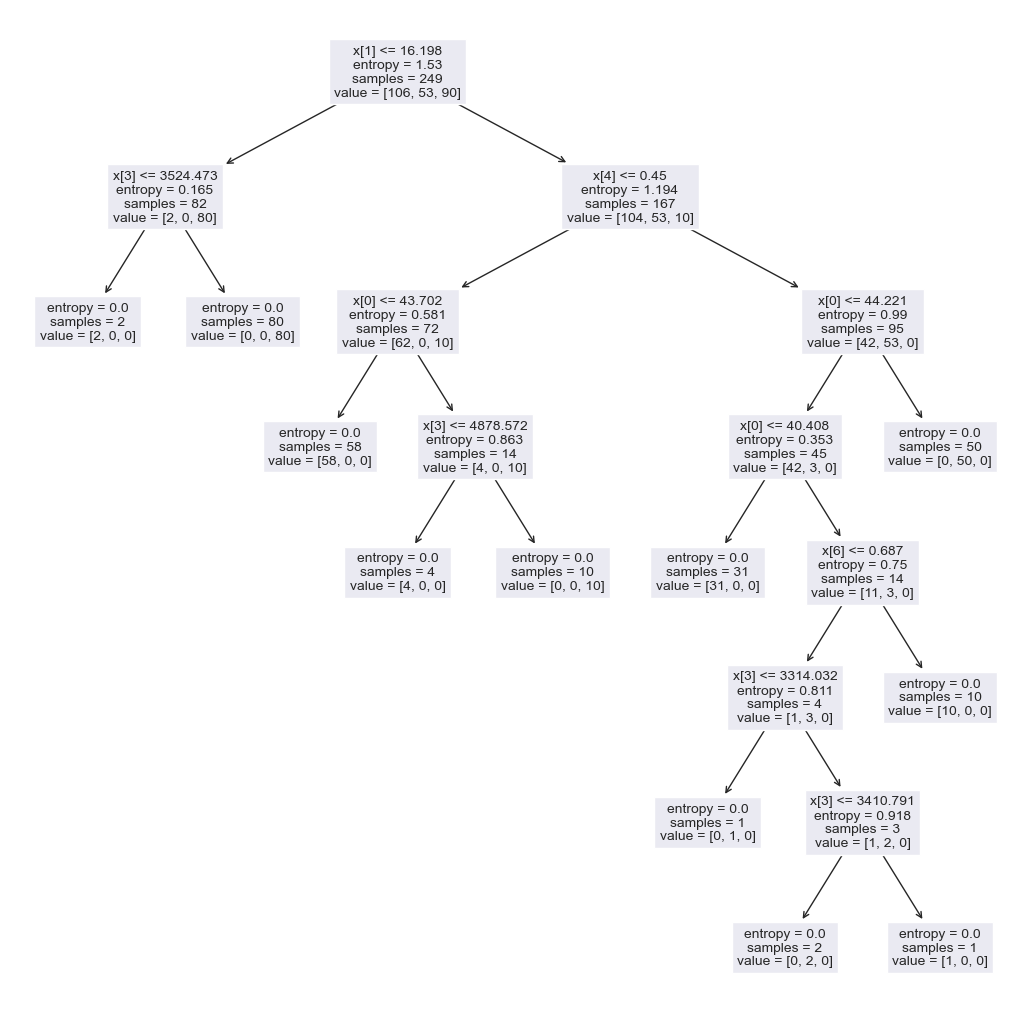

In [17]:
# plotting the model in the form of tree
plt.figure(figsize=(13,13))
tree.plot_tree(dtClfRnd,  fontsize=10)
plt.show()

In [18]:
# predicting the values with the help of unseen data (test data)
yPenPred = dtClfRnd.predict(XPenTest)
yPenPred

array([2, 2, 1, 0, 2, 2, 2, 0, 1, 2, 0, 2, 2, 0, 1, 2, 0, 0, 0, 0, 1, 2,
       0, 2, 0, 1, 1, 2, 2, 0, 0, 1, 0, 0, 0, 1, 2, 2, 0, 2, 0, 2, 2, 1,
       1, 0, 2, 0, 2, 0, 2, 0, 0, 2, 2, 2, 2, 0, 0, 0, 2, 0, 0, 1, 1, 0,
       0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 1, 0, 2, 2, 0, 0, 1])

In [19]:
# computing the accuracy of the model
accuracy_score(yPenTest,yPenPred)

0.9761904761904762

In [20]:
dtClfRnd.score(XPenTest, yPenTest)

0.9761904761904762

In [21]:
print('Train:',dtClfRnd.score(XPenTrain, yPenTrain))
print('Test:', dtClfRnd.score(XPenTest, yPenTest))

Train: 1.0
Test: 0.9761904761904762


**Train score = 1.0**, overfitting

To prevent this, we use pruning

In [22]:
dtClfRnd = tree.DecisionTreeClassifier(splitter='random', criterion='entropy', max_depth = 4)
# fitting our model
dtClfRnd.fit(XPenTrain, yPenTrain)

DecisionTreeClassifier(criterion='entropy', max_depth=4, splitter='random')

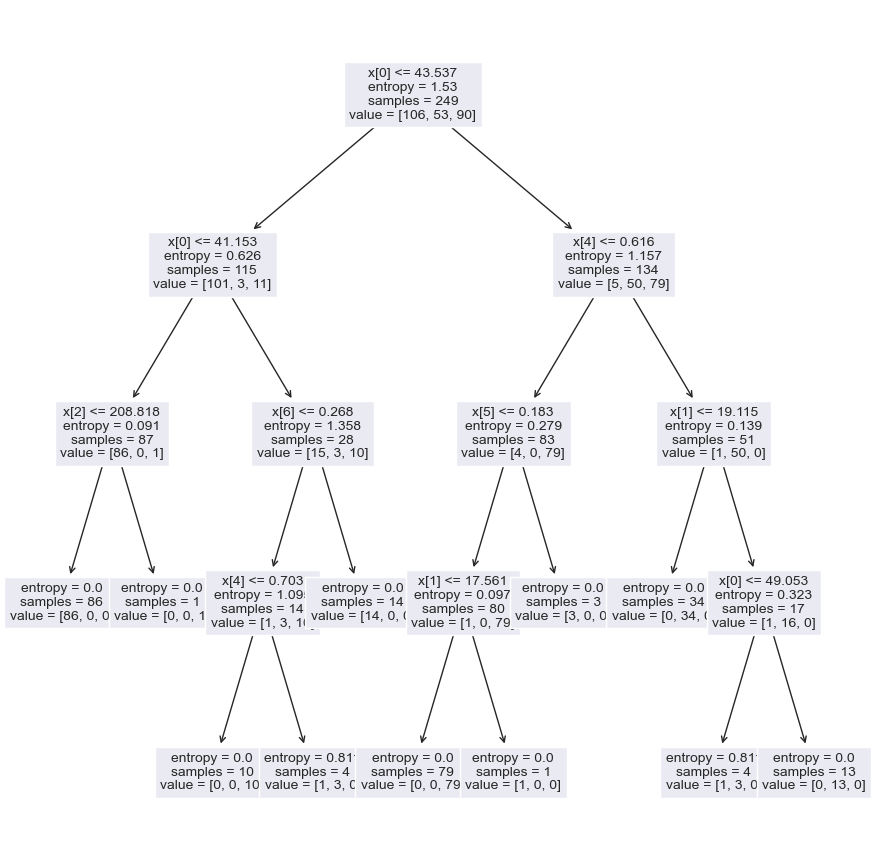

In [23]:
# plotting the model in the form of tree
plt.figure(figsize=(13,13))
tree.plot_tree(dtClfRnd,  fontsize=10)
plt.show()

In [24]:
# predicting the values with the help of unseen data (test data)
yPenPred = dtClfRnd.predict(XPenTest)
# computing the accuracy of the model
accuracy_score(yPenTest,yPenPred)

0.9880952380952381

In [25]:
print('Train:',dtClfRnd.score(XPenTrain, yPenTrain))
print('Test:', dtClfRnd.score(XPenTest, yPenTest))


Train: 0.9919678714859438
Test: 0.9880952380952381


In [26]:
# definning our model
dtClfBest = tree.DecisionTreeClassifier(splitter='best')
dtClfBest.get_params()

{'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': None,
 'splitter': 'best'}

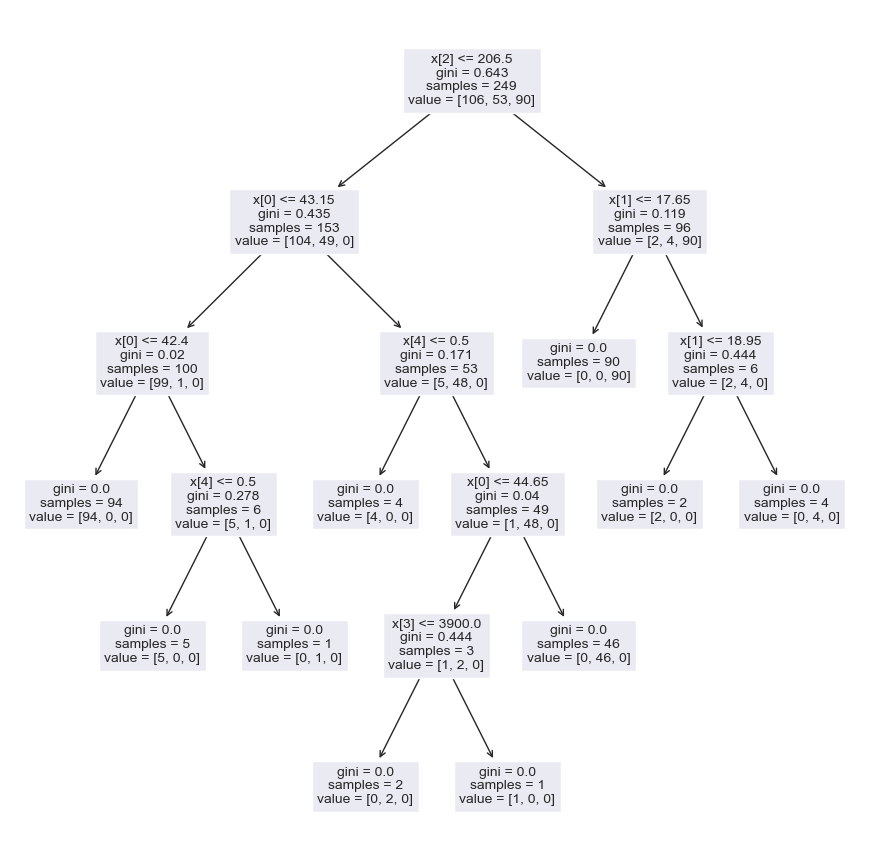

In [27]:

# fitting our model
dtClfBest.fit(XPenTrain, yPenTrain)
# plotting the model in the form of tree
plt.figure(figsize=(11, 11))
tree.plot_tree(dtClfBest, fontsize=10)
plt.show()

In [28]:
# predicting the values with the help of unseen data (test data)
yPenPred = dtClfBest.predict(XPenTest)
yPenPred
# computing the accuracy of the model
accuracy_score(yPenTest, yPenPred)

0.9761904761904762

In [29]:
print('Train:',dtClfBest.score(XPenTrain, yPenTrain))
print('Test:', dtClfBest.score(XPenTest, yPenTest))

Train: 1.0
Test: 0.9761904761904762



<font color=red size='5'>**Logistic Regression (LR)**</font> 
----
----



- Logistic regression, despite its name, is a linear model for classification rather than regression. It belongs to a class of `predictive models` called *Generalized Linear Models (GLM)*. LR is also known in the literature as **logit regression**, maximum-entropy classification (MaxEnt) or the log-linear classifier. In this model, the probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

- Different from Linear regression -- it can predict the probabilities associated with a success or a failure. 
     - Is this email likely spam? 
     - Is this tumor likely to be malignant or benign?
 
 
-  In statistics, the (binary) logistic model (or logit model) is a statistical model that models the probability of one event (out of two alternatives) taking place by having the log-odds (the logarithm of the odds) for the event be a linear combination of one or more independent variables ("predictors") [[*Wikipedia*]](https://en.wikipedia.org/wiki/Logistic_regression)

    - The **odds** of an outcome are the ratio of the probability that the outcome occurs to the probability that the outcome does not occur. In mathematical terms, where $p$ is the probability of the outcome and $1-p$ is the probability that the outcome does not occur:  

        - **odds** $\, = \, \frac{p}{1-p}$
        

----
<img src="logisticReg.png"  width="55%" height="55%">

-----

Let's say we've constructed our best-fit line, i.e. our linear predictor, 
<p>
$$\hat{L} = \beta_0 + \beta_1x+\beta_2 x^2+...+\beta_n x^n$$
    
### A standard sigmoid function:

$$ S(x) = \frac{e^x}{1+e^{x}} = \frac{1}{1+e^{-x}} $$
    
Consider the following transformation: 

$$\hat{y} = \frac{1}{1+e^{-(\hat{L})}} = \frac{1}{1+e^{-(\beta_0 + \beta_1x+...+\beta_n x^n)}}$$

This function squeezes our predictions between 0 and 1.

------   
    
Suppose, we are building a model to predict whether the cancer is benign (1) or malignant (0)

The class labels are mapped to '1' for indicating **benign** and '0' for indicating **malignant**.


How do we fit a line to our dependent variable if its values are already stored as probabilities? We can use the inverse of the sigmoid function, and just set our regression equation equal to that. The inverse of the sigmoid function is called the logit function, and it looks like this:

$$f(y) = ln\, \Bigg(\frac{y}{1-y}\Bigg) $$

Notice that the domain of this function is (0,1).

-----

`Proof that logit and sigmoid are inverse functions:`

$ x = \frac{1}{1+e^{-y}} $ 

so, $1 + e^{-y} = \frac{1}{x}$, 

then $e^{-y} = \frac{1-x}{x}$, 

take take log of both sides; $-y = ln\, (\frac{1-x}{x})$; 

so we can arrange $y = ln\, (\frac{x}{1-x})$

---------        

Our regression equation will now look like this:

$ ln\, \bigg(\frac{y}{1-y}\bigg) = \beta_0 + \beta_1x+\beta_2 x^2+...+\beta_n x^n$    
    
    
The LR model takes real-valued inputs and makes a prediction as to the probability of the input belonging to the default class (class 0).

If the probability is > 0.5 we can take the output as a prediction for the default class (class 0), otherwise the prediction is for the other class (class 1).
        

<font color=maroon size='4'>**LR with scikit-learn**</font> 
----
----


Logistic regression is implemented in `LogisticRegression`. This implementation can fit binary, One-vs-Rest, or multinomial logistic regression.



- **`penalty :`** {'l1', 'l2', 'elasticnet', None}, default='l2'
    Specify the norm of the penalty:

    - `None`: no penalty is added;
    - `'l2'`: add a L2 penalty term and it is the default choice;
    - `'l1'`: add a L1 penalty term;
    - `'elasticnet'`: both L1 and L2 penalty terms are added.


- **`C`** : float, default=1.0
    Inverse of regularization strength; must be a positive float.
    Like in support vector machines, smaller values specify stronger
    regularization.

-----

- random_state : int, RandomState instance, default=None
    Used when ``solver`` == 'sag', 'saga' or 'liblinear' to shuffle the
    data. See :term:`Glossary <random_state>` for details.

- **`solver:`** {'lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'},   default='lbfgs'

    Algorithm to use in the optimization problem. Default is 'lbfgs'.
    To choose a solver, you might want to consider the following aspects:

        - For small datasets, 'liblinear' is a good choice, whereas 'sag'
          and 'saga' are faster for large ones;
        - For multiclass problems, only 'newton-cg', 'sag', 'saga' and
          'lbfgs' handle multinomial loss;
        - 'liblinear' is limited to one-versus-rest schemes.
        - 'newton-cholesky' is a good choice for `n_samples` >> `n_features`,
          especially with one-hot encoded categorical features with rare
          categories. Note that it is limited to binary classification and the
          one-versus-rest reduction for multiclass classification. Be aware that
          the memory usage of this solver has a quadratic dependency on
          `n_features` because it explicitly computes the Hessian matrix.

    - The choice of the algorithm depends on the penalty chosen.
      - Supported penalties by solver:

           - 'lbfgs'           -   ['l2', None]
           - 'liblinear'       -   ['l1', 'l2']
           - 'newton-cg'       -   ['l2', None]
           - 'newton-cholesky' -   ['l2', None]
           - 'sag'             -   ['l2', None]
           - 'saga'            -   ['elasticnet', 'l1', 'l2', None]

    .. note::
       'sag' and 'saga' fast convergence is only guaranteed on features
       with approximately the same scale. 
       
       
- **`max_iter:`** int, default=100
    Maximum number of iterations taken for the solvers to converge.



### Breast Cancer Data Set: 

##### Predict whether the cancer is benign [iyi huylu] or malignant [kötü huylu]

**Attribute Information:**


- Diagnosis (M = malignant, B = benign)

- radius (mean of distances from center to points on the perimeter)

- texture (standard deviation of gray-scale values)

- perimeter

- area

- smoothness (local variation in radius lengths)

- compactness (perimeter^2 / area - 1.0)

- concavity (severity of concave portions of the contour)

- concave points (number of concave portions of the contour)

- symmetry

- fractal dimension ("coastline approximation" - 1)

- The mean, standard error and "worst" or largest (mean of the three largest values) of these features were computed for each image, resulting in 30 features. For instance, field 3 is Mean Radius, field 13 is Radius SE, field 23 is Worst Radius.

- All feature values are recoded with four significant digits.

- Missing attribute values: none

- Class distribution: 

    - diagnosis (M = malignant, B = benign)
    
        - 212: malignant
        - 357: benign

In [30]:
# import some data to play with
from sklearn import datasets
from sklearn.metrics import accuracy_score

In [31]:
from sklearn.datasets import load_breast_cancer

cancerData = load_breast_cancer()

In [32]:
cancerData.target[0:30]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0])

In [33]:
cancerData.target_names

array(['malignant', 'benign'], dtype='<U9')

In [34]:
cancerData.feature_names  #column names

array(['mean radius', 'mean texture', 'mean perimeter', 'mean area',
       'mean smoothness', 'mean compactness', 'mean concavity',
       'mean concave points', 'mean symmetry', 'mean fractal dimension',
       'radius error', 'texture error', 'perimeter error', 'area error',
       'smoothness error', 'compactness error', 'concavity error',
       'concave points error', 'symmetry error',
       'fractal dimension error', 'worst radius', 'worst texture',
       'worst perimeter', 'worst area', 'worst smoothness',
       'worst compactness', 'worst concavity', 'worst concave points',
       'worst symmetry', 'worst fractal dimension'], dtype='<U23')

In [35]:
cancerDf = pd.DataFrame(cancerData.data, columns=cancerData.feature_names)
cancerDf['target']=cancerData.target
cancerDf.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [36]:
cancerDf = cancerDf.dropna()
cancerDf.target.value_counts()

target
1    357
0    212
Name: count, dtype: int64

In [37]:
cancerDf.describe().T

,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


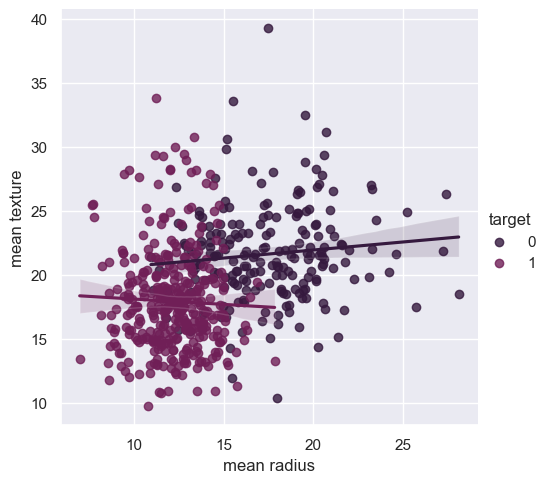

In [38]:
sns.lmplot( data = cancerDf, x = 'mean radius', y = 'mean texture', hue = 'target')

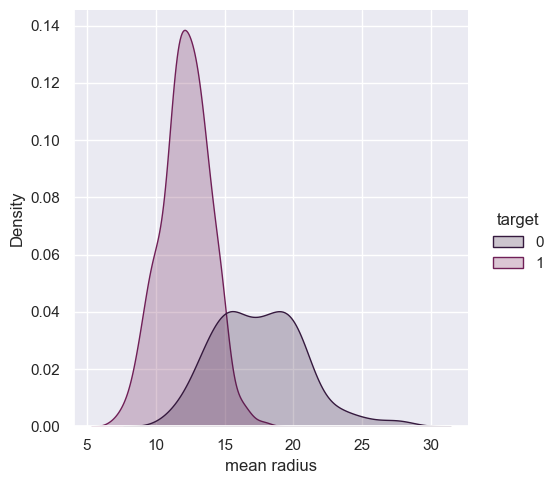

In [39]:
sns.displot(data=cancerDf, x='mean radius', hue='target', kind='kde', fill=True)

<Axes: xlabel='mean radius', ylabel='target'>

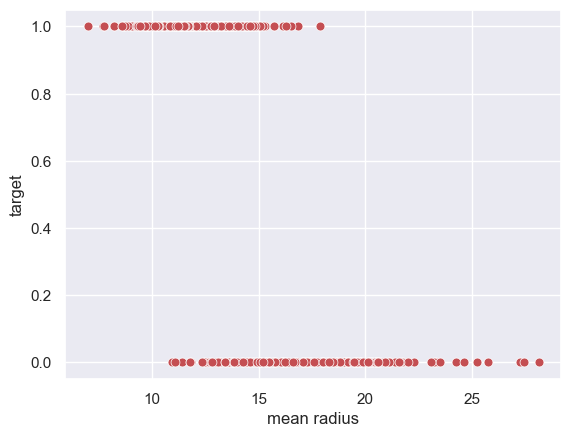

In [40]:
sns.scatterplot(data=cancerDf, x = 'mean radius', y='target', color='r', s = 41)

In [41]:
from sklearn.linear_model import LogisticRegression

In [42]:
XCan = cancerData.data
yCan = cancerData.target
XCanTrain, XCanTest, yCanTrain, yCanTest = train_test_split(XCan, yCan, random_state=21)

In [43]:
#Create an instance of the model
lrClf = LogisticRegression(max_iter=2500)

In [44]:
lrClf.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 2500,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [45]:
#Fit the Model to the Data

lrClf.fit(XCanTrain, yCanTrain)

LogisticRegression(max_iter=2500)

In [46]:
#Create an instance of the model
lrClf = LogisticRegression(max_iter = 2000)
#Fit the Model to the Data

lrClf.fit(XCanTrain, yCanTrain)

LogisticRegression(max_iter=2000)

In [47]:
#MODEL ACCURACY
lrClf.score(XCanTest, yCanTest)  # Generates 93% accuracy using LOGISTIC REGRESSION MODEL
#Generated accuracy of 93%

0.9300699300699301

In [48]:
#Predicts labels for test data
yPredLr = lrClf.predict(XCanTest)   
accuracy_score(yPredLr, yCanTest)

0.9300699300699301

In [49]:
patient1 = [14.42,19.77,94.48,642.5,0.09752,0.1141,0.09388,0.05839,0.1879,0.0639,0.2895,1.851,2.376,26.85,0.008005,0.02895,0.03321,0.01424,0.01462,0.004452,16.33,30.86,109.5,826.4,0.1431,0.3026,0.3194,0.1565,0.2718,0.09353]
patient1 = np.array([patient1])
patient1

array([[1.442e+01, 1.977e+01, 9.448e+01, 6.425e+02, 9.752e-02, 1.141e-01,
        9.388e-02, 5.839e-02, 1.879e-01, 6.390e-02, 2.895e-01, 1.851e+00,
        2.376e+00, 2.685e+01, 8.005e-03, 2.895e-02, 3.321e-02, 1.424e-02,
        1.462e-02, 4.452e-03, 1.633e+01, 3.086e+01, 1.095e+02, 8.264e+02,
        1.431e-01, 3.026e-01, 3.194e-01, 1.565e-01, 2.718e-01, 9.353e-02]])

In [50]:
lrClf.predict(patient1)

array([0])

<font color=red size='5'>**Naïve Bayes Classifier**</font> 
----
----



A Naive Bayes (NB) classifier is a probabilistic ML model that’s used for classification task. The crux of the classifier is based on the Bayes’ theorem, and the adjective naive comes from the assumption that **the features in a dataset are mutually independent**. In practice, the independence assumption is often violated, but NB classifiers still tend to perform very well under this unrealistic assumption. Especially for small sample sizes, NB classifiers can outperform the more powerful alternatives.


<font color=maroon size='4'>**Bayes' rule:**</font> 
----
----


$$ P(A|B)\,=\,\frac{P(B|A)P(A)}{P(B)}\,=\,\frac{P(B|A)P(A)}{P(B|A)P(A)+P(B|\neg A)P(\neg A)} $$


----
<img src="NaivebayesEq.png"  width="35%" height="35%">

-----


Bayes’ theorem states the following relationship, given class variable  and dependent feature vector $x_1$ through $x_n$:

$$P(y \mid x_1, \dots, x_n) = \frac{P(y) P(x_1, \dots, x_n \mid y)} {P(x_1, \dots, x_n)}$$

Using the naive conditional independence assumption that



$$P(x_i | y, x_1, \dots, x_{i-1}, x_{i+1}, \dots, x_n) = P(x_i | y)$$


for all $i$, this relationship is simplified to



$$P(y \mid x_1, \dots, x_n) = \frac{P(y) \prod_{i=1}^{n} P(x_i \mid y)}  {P(x_1, \dots, x_n)}$$



Since $P(x_1, \dots, x_n)$ is constant given the input, we can use the following classification rule:

 
 
$$\begin{align}\begin{aligned}P(y \mid x_1, \dots, x_n) \propto P(y) \prod_{i=1}^{n} P(x_i \mid y)\\\Downarrow\\\hat{y} = \arg\max_y P(y) \prod_{i=1}^{n} P(x_i \mid y),\end{aligned}\end{align}$$


and we can use Maximum A Posteriori (MAP) estimation to estimate $P(y)$ and 
$P(x_i \mid y)$; the former is then the relative frequency of class $y$ in the training set.

The different naive Bayes classifiers differ mainly by the assumptions they make regarding the distribution of $P(x_i \mid y)$.


There are three types of NB models: Gaussian, Multinomial, and Bernoulli.

    1- Gaussian NB:  supports continuous values and has an assumption that each class is normally distributed. 

    2- Multinomial NB:  is an event-based model that has features as vectors where sample(feature) represents frequencies with which certain events have occurred.
    
    3- Bernoulli NB:  is also event-based where features are independent boolean which are in binary form.
    

In spite of their apparently over-simplified assumptions, BN classifiers have worked quite well in many real-world situations, famously document classification and spam filtering. They require a small amount of training data to estimate the necessary parameters. 


NB learners and classifiers can be extremely fast compared to more sophisticated methods. The decoupling of the class conditional feature distributions means that each distribution can be independently estimated as a one dimensional distribution. This in turn helps to alleviate problems stemming from the curse of dimensionality.

<font color=maroon size='4'>**NB classifier with scikit-learn**</font> 
----
----

#### Gaussian Naive Bayes


`GaussianNB` implements the Gaussian NB algorithm for classification. The likelihood of the features is assumed to be Gaussian:



$$P(x_i \mid y) = \frac{1}{\sqrt{2\pi\sigma^2_y}} \exp\left(-\frac{(x_i - \mu_y)^2}{2\sigma^2_y}\right)$$

In [51]:
# Model specific Library
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

In [52]:
bayesClfGaus = GaussianNB()
bayesClfGaus.fit(XCanTrain, yCanTrain)
bayesClfGaus.score(XCanTest, yCanTest)

0.9230769230769231

In [53]:
yPredGnb = bayesClfGaus.predict(XCanTest)   
accuracy_score(yPredGnb, yCanTest)

0.9230769230769231

In [54]:
bayesClfGaus.predict(patient1)

array([1])

#### Multinomial Naive Bayes


`MultinomialNB` implements the NB algorithm for multinomially distributed data, and is one of the two classic NB variants used in text classification. The distribution is parametrized by vectors $\theta_y=(\theta_{y1},\ldots,\theta_{yn})$ for each class $y$, where $n$ is the number of features and $\theta_{yi}$ is the probability $P(x_i \mid y)$ of feature $i$ appearing in a sample belonging to class $y$.
 
The parameters $\theta_y$ is estimated by a smoothed version of maximum likelihood, i.e. relative frequency counting:
 
 
 $$\hat{\theta}_{yi} = \frac{ N_{yi} + \alpha}{N_y + \alpha n}$$
 
 
where $N_{yi} = \sum_{x \in T} x_i$ is the number of times feature $i$ appears in a sample of class $y$ in the training set $T$, and $N_{y} = \sum_{i=1}^{n} N_{yi}$ is the total count of all features for class $y$.

The smoothing priors $\alpha \ge 0$ accounts for features not present in the learning samples and prevents zero probabilities in further computations. Setting  $\alpha = 0$ is called Laplace smoothing, while  $\alpha < 1$ is called Lidstone smoothing.

In [55]:
bayesClfMn = MultinomialNB()
bayesClfMn.fit(XCanTrain, yCanTrain)
bayesClfMn.score(XCanTest, yCanTest)

0.8811188811188811

In [56]:
yPredMnb = bayesClfMn.predict(XCanTest)   
accuracy_score(yPredMnb, yCanTest)

0.8811188811188811

In [57]:
bayesClfMn.predict(patient1)

array([1])

NOTE: Score goes down when compared to Gaussian NB.


#### Bernoulli Naive Bayes

`BernoulliNB` implements the NB training and classification algorithms for data that is distributed according to multivariate Bernoulli distributions; i.e., there may be multiple features but each one is assumed to be a binary-valued (Bernoulli, boolean) variable. Therefore, this class requires samples to be represented as binary-valued feature vectors; if handed any other kind of data, a `BernoulliNB` instance may binarize its input (depending on the binarize parameter).

The decision rule for Bernoulli naive Bayes is based on

$$P(x_i \mid y) = P(i \mid y) x_i + (1 - P(i \mid y)) (1 - x_i)$$

which differs from multinomial NB’s rule in that it explicitly penalizes the non-occurrence of a feature $i$ that is an indicator for class $y$, where the multinomial variant would simply ignore a non-occurring feature.

In the case of text classification, word occurrence vectors (rather than word count vectors) may be used to train and use this classifier. `BernoulliNB` might perform better on some datasets, especially those with shorter documents. It is advisable to evaluate both models, if time permits.

In [58]:
bayesClfBr = BernoulliNB()
bayesClfBr.fit(XCanTrain, yCanTrain)
bayesClfBr.score(XCanTest, yCanTest)

0.6503496503496503

In [59]:
yPredBnb = bayesClfBr.predict(XCanTest)   
accuracy_score(yPredBnb, yCanTest)

0.6503496503496503

In [60]:
bayesClfBr.predict(patient1)

array([1])

<font color=red size='5'>**K-Nearest Neighbors (K-NN) Classifier**</font> 
----
----


- K-Nearest Neighbour is one of the simplest ML algorithms based on Supervised Learning technique. K-NN algorithm can be used for regression as well as for classification but mostly it is used for the classification problems.

- K-NN is an example of a <b>non-parametric</b> model for classification in a supervised learning context, namely the <b>k-nearest neighbor (k-NN)</b> classifier. Parametric models of the unconditional $p(y \,|\, \boldsymbol{\theta})$ or conditional form $p(y \,|\, \mathbf{x}, \boldsymbol{\theta})$ are either provided parameters $\boldsymbol{\theta} \in \mathbb{R}^n$ or derive them via model fitting on some dataset $\mathcal{D}$. On the other hand, non-parametric models make no assumption about the underlying distribution of the data $\mathcal{D}$, and are free to learn any functional approximation over the data.

- K-NN algorithm assumes the similarity between the new case/data and available cases and put the new case into the category that is most similar to the available categories.

- K-NN algorithm stores all the available data and classifies a new data point based on the similarity. This means when new data appears then it can be easily classified into a well suite category by using K-NN algorithm.

- K-NN is a non-parametric algorithm, which means it does not make any assumption on underlying data.

- It is also called a lazy learner algorithm because it doesn’t learn a discriminative function from the training data instead it stores (“memorizes”) the dataset and at the time of classification, it performs an action on the dataset.


- K-NN algorithm at the training phase just stores the dataset and when it gets new data, then it classifies that data into a category that is much similar to the new data.



----
<img src="knnC.png"  width="45%" height="45%">

-----


K-NN is a similarity based algorithm - the class membership of the observation depends on the feature similarity to training observations.

The similarity depends on the distance of observations from each other, which can be calculated using any of the distance metrics. 

The most commonly used distance metric is the Euclidean distance. However, which distance metric you use as well as the value of $K$ could affect the performance of your model. The decision boundary can change accordingly to different values of $K$.

<font color=maroon size='4'>**Distance Metrics**</font> 
----
----


#### Manhattan Distance ($L1-norm$)
The Manhattan distance is the sum of the absolute values of the Cartesian coordinates. You can think of Manhattan distance as moving through grids. In the image below, only the green line is infeasible to calculate the Manhattan distance. The equation for calculating Manhattan distance is

$$ d\left( x,y\right)   = \sum _{i=1}^{n} |\,x_{i}-y_{i}\,|  $$



----
<img src="mhtn.png"  width="35%" height="35%">

-----

#### Euclidean Distance ($L2-norm$)
Euclidean distance is the shortest distance between two points, and it is the most common used distance metrics. To calculate the Euclidean distance between two coordinates a(x1,y1) and b(x2,y2), the formula is:

$$ d\left( x,y\right)   = \sqrt {\sum _{i=1}^{n}  \left( x_{i}-y_{i}\right)^2 } $$


----


#### Minkowski Distance ($L\rho-norm$)
Minkowski distance is a generalized format for calculating distance in n-dimensional normed vector space. It takes on the formula of:

 $$d\left(x,y\right) = \sqrt[\rho]{\sum _{i=1}^{n}  \left( x_{i}-y_{i}\right)^{\rho}}$$
 

As you can see, the Manhattan Distance and Euclidean distance are special cases of the Minkowski Distance. The Manhattan distance takes on the notation of l1 norm and Euclidean distance takes on the notation of l2 norm. What does this remind you of?


---

<font color=maroon size='4'>**KNN  classifier with scikit-learn**</font> 
----
----


- `KNeighborsClassifier` is classifier implementing the k-nearest neighbors vote.

- **`n_neighbors:`** int, default=5
    Number of neighbors to use by default for :meth:`kneighbors` queries.

- **`weights:`** {'uniform', 'distance'}, callable or None, default='uniform'
    Weight function used in prediction.  Possible values:

    - 'uniform' : uniform weights.  All points in each neighborhood
      are weighted equally.
    - 'distance' : weight points by the inverse of their distance.
      in this case, closer neighbors of a query point will have a
      greater influence than neighbors which are further away.
    - [callable] : a user-defined function which accepts an
      array of distances, and returns an array of the same shape
      containing the weights.


metric : str or callable, default='minkowski'
    Metric to use for distance computation. Default is "minkowski", which
    results in the standard Euclidean distance when p = 2. See the
    documentation of `scipy.spatial.distance
    <https://docs.scipy.org/doc/scipy/reference/spatial.distance.html>`_ and
    the metrics listed in
    :class:`~sklearn.metrics.pairwise.distance_metrics` for valid metric
    values.

    If metric is "precomputed", X is assumed to be a distance matrix and
    must be square during fit. X may be a :term:`sparse graph`, in which
    case only "nonzero" elements may be considered neighbors.

    If metric is a callable function, it takes two arrays representing 1D
    vectors as inputs and must return one value indicating the distance
    between those vectors. This works for Scipy's metrics, but is less
    efficient than passing the metric name as a string.

In [61]:
# KNeighbors Classifier
from sklearn.neighbors import KNeighborsClassifier

knnClf = KNeighborsClassifier(n_neighbors = 1)

# Model is learning the relationship between X and y
knnClf.fit(XCanTrain, yCanTrain)

# Make predictions
yPredKnn = knnClf.predict(XCanTest)

C:\Users\guludag\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\guludag\Anaconda3\lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


In [62]:
accuracy_score(yPredKnn, yCanTest)

0.916083916083916

In [63]:
knnClf = KNeighborsClassifier(n_neighbors = 5)
knnClf.fit(XCanTrain, yCanTrain)
yPredKnn = knnClf.predict(XCanTest)
accuracy_score(yPredKnn, yCanTest)

0.9090909090909091

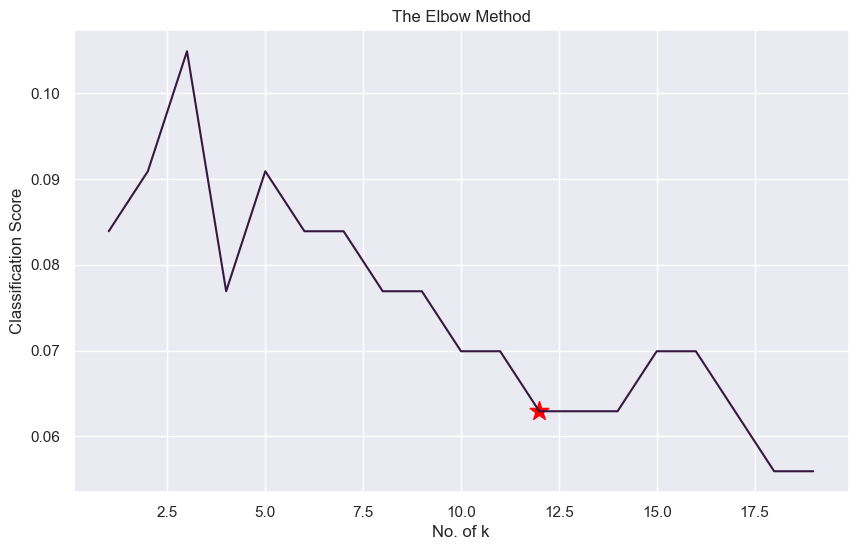

In [64]:
classScore = []
for i in range(1, 20):
    knnClf = KNeighborsClassifier(n_neighbors = i)
    knnClf.fit(XCanTrain, yCanTrain)    
    classScore.append(1-knnClf.score(XCanTest, yCanTest)) 
    # inertia_ = Sum of squared distances of samples to their closest cluster center.
    

plt.figure(figsize=(10,6))
plt.plot(range(1, 20), classScore)
plt.scatter(12, classScore[12], s = 200, c = 'red', marker='*')
plt.title('The Elbow Method')
plt.xlabel('No. of k')
plt.ylabel('Classification Score')
plt.show()


<font color=red size='5'>**Evaluating Classification Models**</font> 
----
----



<font color=maroon size='4'>**Jaccard index**</font> 
----
----


Let's try the jaccard index for accuracy evaluation. We can define jaccard as the size of the intersection divided by the size of the union of the two label sets. If the entire set of predicted labels for a sample strictly matches with the true set of labels, then the subset accuracy is 1.0; otherwise it is 0.0.

- Jaccard Similarity of two sets $U$ and $V$.

$$Jaccard(U,V) = \frac{|U \cap V|}{|U \cup V|}$$


In [65]:
accuracy_score(yPredLr, yCanTest)

0.9300699300699301

In [66]:
#For logistic resgression
from sklearn.metrics import jaccard_score
jaccard_score(yCanTest, yPredLr, pos_label=0)

0.8113207547169812

<font color=maroon size='4'>**Log loss**</font> 
----
----

Log loss (Logarithmic loss) measures the performance of a classifier where the predicted output is a probability value between 0 and 1.

$$ LogLoss = - \frac{1}{n} \sum\limits_{i=1}^n [y_i \cdot log_e(\hat{y_i}) + (1-y_i) \cdot log_e(1-\hat{y_i}) ] $$

where $n$ is the number of games played, $\hat{y_i}$ is the predicted probability of team1 beating team2, $y_i$ is 1 if team1 wins and 0 if team2 wins. Smaller LogLoss is better. 

In [67]:
#Predicts probability, useful also in log loss calculations
yPredProbLr = lrClf.predict_proba(XCanTest)   


In [68]:
from sklearn.metrics import log_loss
log_loss(yCanTest, yPredProbLr)

0.12821554284192294

<font color=maroon size='4'>**Confusion matrix**</font> 
----
----


Another way of looking at the accuracy of the classifier is to look at **confusion matrix**.

For classification problems, the target is a categorical variable. This means that we can simply count the number of times that our model predicts the correct category and the number of times that it predicts something else.

We can visualize this by means of a confusion matrix, a tabular representation of Actual vs Predicted values.


----
<img src="confusionMatrix.png"  width="45%" height="45%">



----
- **True Positive (TP):** Interpretation: You predicted positive and it’s true.
<p>
- **True Negative (TN):** Interpretation: You predicted negative and it’s true.
<p>
- **False Positive (FP): (Type 1 Error:  $\alpha$)** Interpretation: You predicted positive and it’s false.
<p>
- **False Negative (FN): (Type 2 Error: $\beta$)** Interpretation: You predicted negative and it’s false.
--------
    
    
-----


- **Precision** = $\frac{TP}{TP+FP}$
<p>

    - **Precision** is the ratio between all correct cancer and the total number of predictive cancers
    
<p><p>
    
- **Recall** = **Sensitivity** = $\frac{TP}{TP+FN}$   
<p>
    
    - **Recall** is the ratio between the correct cancer predictions over the total number of cancer cases
    
<p><p>
    
- **Specificity** = $\frac{TN}{FP+TN}$   
    
    - **False Positive Rate (FPR)** = (1-Specificity)
    
<p><p>
    
- **Accuracy** = $\frac{TP+TN}{TP+TN+FP+FN}$

<p><p>    
    
- **F1** = $\frac{2*Precision*Recall}{Precision+Recall} = \frac{2*TP}{2*TP+FP+FN}$
<p>
    
    - The F1 score is the harmonic average of the precision and recall, where an F1 score reaches its best value at 1 (perfect precision and recall) and worst at 0. It is a good way to show that a classifer has a good value for both recall and precision.    
-----    

In [69]:
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
CM = metrics.confusion_matrix(yCanTest, yPredLr, labels=[0,1])
print(CM)

[[43  7]
 [ 3 90]]


### Plot Confusion Matrix

In [70]:
CM = np.array(confusion_matrix(yCanTest, yPredLr, labels=[0,1]))

confMat= pd.DataFrame(CM, index = ['cancer', 'healthy'],
                           columns =['predicted_cancer','predicted_healthy'])

confMat

,predicted_cancer,predicted_healthy
cancer,43,7
healthy,3,90


<Axes: >

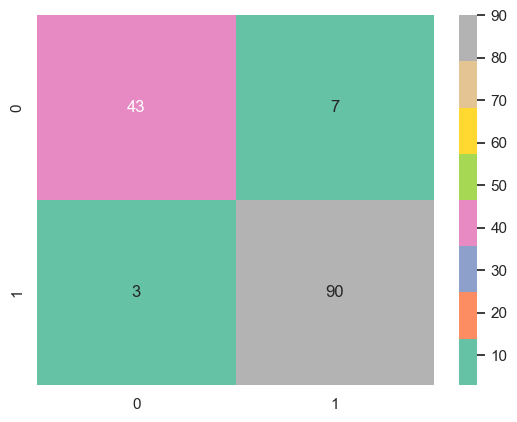

In [71]:
sns.heatmap(CM, annot=True,fmt='g',cmap='Set2')

In [72]:
#Shows PRECISION, RECALL, F1 SCORE
print (classification_report(yCanTest, yPredLr))


              precision    recall  f1-score   support

           0       0.93      0.86      0.90        50
           1       0.93      0.97      0.95        93

    accuracy                           0.93       143
   macro avg       0.93      0.91      0.92       143
weighted avg       0.93      0.93      0.93       143



<font color=maroon size='4'>**ROC Curve Transforms**</font> 
----
----


- The Receiver Operating Characteristic (ROC) curve is a probability curve that illustrates how good our binary classification is in classifying classes based on true-positive rates (TPR) and false-positive rates (FPR).


- The Area Under Curve (AUC) is a metric that ranges from 0 to 1. It is the area under the ROC curve.


- We need to find a good balance between recall and false-positive rates. 

    - **False Positive Rate (FPR):** $FPR = \frac{FP}{TN+FP}$  
        
        - Also calculated by (1-Specificity) 
    
    - **True Positive Rate (TPR)**: $TPR = \frac{TP}{TP+FN}$ 
    
        - Also known as Recall.  TPR is the ratio between the correct cancer predictions over the total number of cancer cases. 


- Precision focuses on how well the model can detect cancer. Conversely, FPR focuses on the failure rate to detect cancer



In [73]:

from sklearn.metrics import precision_score, recall_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_auc_score,auc,f1_score
from sklearn.metrics import precision_recall_curve,roc_curve


In [74]:

yScore = lrClf.fit(XCanTrain, yCanTrain).decision_function(XCanTest)
FPR, TPR, thresholds = roc_curve(yCanTest, yScore)


The model that we are going to use is the LR. Usually, when we apply classification, the outputs are already rounded off by some **threshold**. ROC curve uses different thresholds to plot the relationship between **TPR-FPR**. Because we want to investigate the relationship between TPR, FPR, and threshold.

In [75]:
ROC_AUC = auc(FPR, TPR)
print (ROC_AUC)


0.9913978494623656


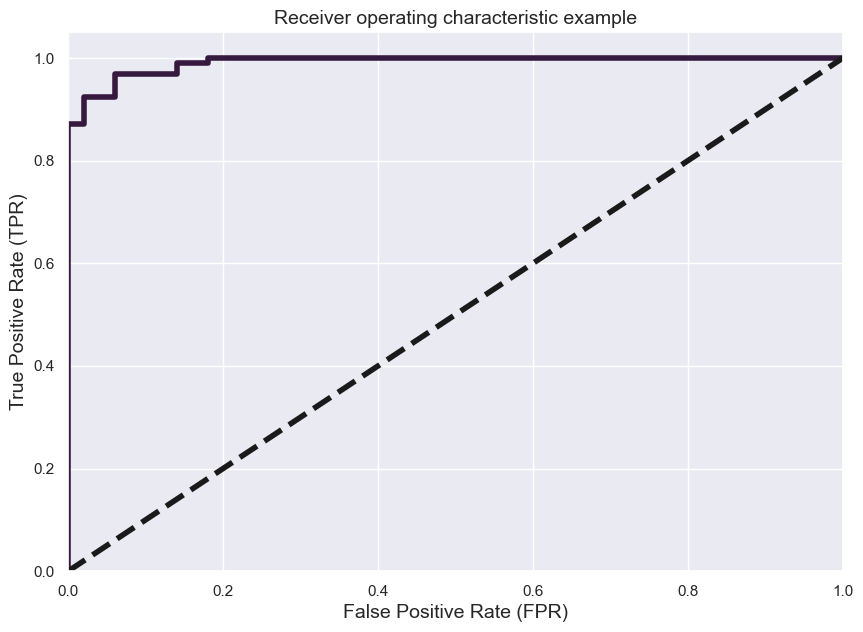

In [76]:

plt.figure(figsize =[10,7])
plt.plot(FPR, TPR, label= 'ROC curve(area = %0.2f)'%ROC_AUC, linewidth= 4)
plt.plot([0,1],[0,1], 'k--', linewidth = 4)
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate (FPR)', fontsize = 14)
plt.ylabel('True Positive Rate (TPR)', fontsize = 14)
plt.title('Receiver operating characteristic example', fontsize= 14)
plt.show()

The ROC curve shows the trade-off between **sensitivity (or TPR) and specificity (1 – FPR)**. As we notice the LR classifier give a curve closer to the top-left corner so it indicate a better performance.

- Black line shows where the TPR = FPR 

- **Area Under Curve (AUC)**:

    - Area Under Curve is a common way to compare classifiers. A perfect classifier will have ROC AUC equal to 1

        - Sckit-Learn provides a function to compute the ROC AUC.

In [77]:
roc_auc_score(yCanTest, yScore)

0.9913978494623656

<font color=red size='5'>**Evaluating estimator performance: Cross-validation**</font> 
----
----


- Learning the parameters of a prediction function and testing it on the same data is a methodological mistake: a model that would just repeat the labels of the samples that it has just seen would have a perfect score but would fail to predict anything useful on yet-unseen data. This situation is called **overfitting**. To avoid it, it is common practice when performing a (supervised) machine learning experiment to hold out part of the available data as a test set X_test, y_test. 


- In scikit-learn a random split into training and test sets can be quickly computed with the `train_test_split` helper function. 


- When evaluating different settings (“hyperparameters”) for estimators, such as the C setting that must be manually set for a classifier, there is still a risk of overfitting on the test set because the parameters can be tweaked until the estimator performs optimally. This way, knowledge about the test set can “leak” into the model and evaluation metrics no longer report on generalization performance. To solve this problem, yet another part of the dataset can be held out as a so-called “validation set”: training proceeds on the training set, after which evaluation is done on the validation set, and when the experiment seems to be successful, final evaluation can be done on the test set.


- However, by partitioning the available data into three sets, we drastically reduce the number of samples which can be used for learning the model, and the results can depend on a particular random choice for the pair of (train, validation) sets.

- A solution to this problem is a procedure called cross-validation (CV for short). A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV. In the basic approach, called k-fold CV, the training set is split into k smaller sets (other approaches are described below, but generally follow the same principles). The following procedure is followed for each of the k “folds”:


----
<img src="xValudation.png"  width="55%" height="55%">

------


    - A model is trained using  of the folds as training data;

    - the resulting model is validated on the remaining part of the data (i.e., it is used as a test set to compute a performance measure such as accuracy).

- The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as is the case when fixing an arbitrary validation set), which is a major advantage in problems such as inverse inference where the number of samples is very small.


for more innformation: (https://scikit-learn.org/stable/modules/cross_validation.html)


-----


<font color=maroon size='4'>**K-fold CV**</font> 
----
----



KFold divides all the samples in  groups of samples, called folds (if $k=n$, this is equivalent to the **Leave One Out** strategy), of equal sizes (if possible). The prediction function is learned using $k-1$  folds, and the fold left out is used for test.

K-fold CV Process:

1) Split the training data into ten "folds", each of the same size

2) Select the first fold to be the "validation" set; the others are the training set

3) Train the algorithm on the training set and evaluate it with the fold that is the validation set

4) Repeat the training and evaluation with the second fold as the validation set

5) Continue until each of the folds has been used as the validation data



In [78]:
#Create an instance of the model
lrClf = LogisticRegression(solver = 'liblinear', max_iter = 3000)
#Fit the Model to the Data

lrClf.fit(XCanTrain, yCanTrain)

LogisticRegression(max_iter=3000, solver='liblinear')

In [79]:
lrClf.score(XCanTest, yCanTest)

0.9440559440559441

In [80]:

from sklearn.model_selection import cross_val_score


In [81]:

cvScores = cross_val_score(lrClf, XCan, yCan, cv=5)
cvScores

array([0.93859649, 0.93859649, 0.97368421, 0.94736842, 0.96460177])

In [82]:
cvScores.mean()

0.9525694767893185

In [83]:
cvScores.std()

0.014199631617252084

By default, the score computed at each CV iteration is the score method of the estimator. It is possible to change this by using the scoring parameter:

In [84]:
scores = cross_val_score(lrClf, XCan, yCan, cv=5, scoring='f1_macro')
scores

array([0.93220627, 0.93369339, 0.97158288, 0.94345238, 0.96245847])

In [85]:
from sklearn.model_selection import ShuffleSplit

n_samples = XCan.shape[0]
CV = ShuffleSplit(n_splits=5, test_size=0.3, random_state=0)
cross_val_score(lrClf, XCan, yCan, cv=CV)

array([0.96491228, 0.95906433, 0.94152047, 0.93567251, 0.94736842])

In [86]:

# evaluate a logistic regression model using k-fold cross-validation
from numpy import mean
from numpy import std
from sklearn.model_selection import KFold


In [87]:

kFoldCV = KFold(n_splits=4, random_state=21, shuffle=True)

scores = cross_val_score(lrClf, XCan, yCan, cv=kFoldCV)

print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.953 (0.021)


<font color=maroon size='4'>**Repeated K-Fold CV**</font> 
----
----


- A single run of the K-fold CV procedure may result in a noisy estimate of model performance. Different splits of the data may result in very different results.

- Repeated K-fold CV provides a way to improve the estimated performance of a ML model. This involves simply repeating the CV procedure multiple times and reporting the mean result across all folds from all runs. 

    - This mean result is expected to be a more accurate estimate of the true unknown underlying mean performance of the model on the dataset, as calculated using the standard error.


- In Scikit-learn, `RepeatedKFold` repeats K-Fold $n$ times.


- Example of 4-fold K-Fold repeated 5 times:

In [88]:
from sklearn.model_selection import RepeatedKFold

In [89]:
rKfCv = RepeatedKFold(n_splits=5, n_repeats=10, random_state=21)
# evaluate model
scores = cross_val_score(lrClf, XCan, yCan, scoring='accuracy', cv=rKfCv)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.951 (0.018)


In [90]:
rKfCv = RepeatedKFold(n_splits=10, n_repeats=20, random_state=21)
# evaluate model
scores = cross_val_score(lrClf, XCan, yCan, scoring='accuracy', cv=rKfCv)
# report performance
print('Accuracy: %.3f (%.3f)' % (mean(scores), std(scores)))

Accuracy: 0.951 (0.026)
